
--- Comparing SDE Conv (Kalman Smoother) vs. Standard Conv (Denoising SDE Signal) (K=3) ---
alpha =  tensor([0.0025, 0.0025, 0.0025, 0.0025])
omega =  tensor([0.3927, 0.3927, 0.3927, 0.3927])
Noise scale =  0.2


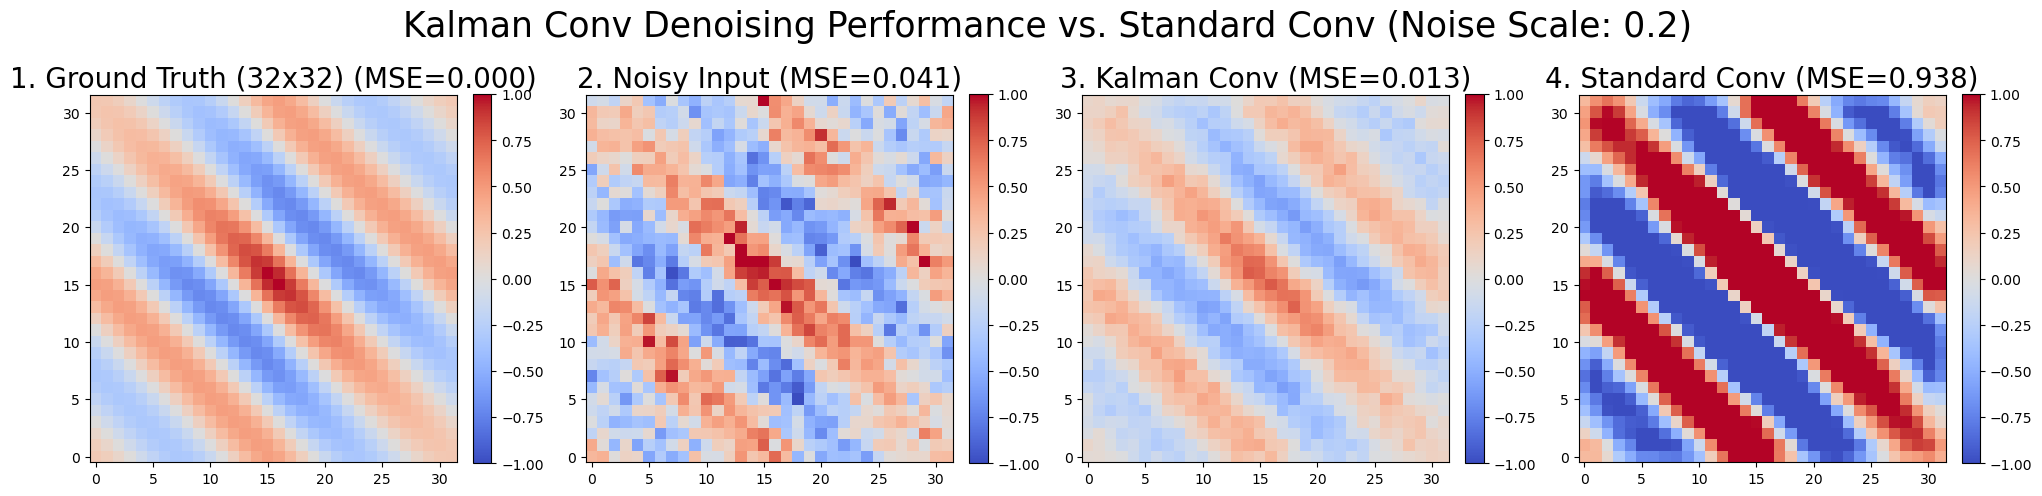


Denoising Test Results:
Initial Noise MSE (Input vs GT): 0.0412
SDE Conv Denoised MSE (Output vs GT): 0.0125
Standard Conv Denoised MSE (Output vs GT): 0.9384
SDE Conv Reduction Factor (vs Noisy): 3.29x
SDE Conv Improvement (vs Standard Conv): 75.00x


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Utility Functions ---

def complex_to_phase_intensity_image(z_r: torch.Tensor, z_i: torch.Tensor) -> np.ndarray:
    """
    Maps a complex tensor (R, I) of shape (N, N) to a single intensity image (N, N)
    based on the Phase (Hue). The phase is normalized to [0, 1] for visualization.
    """
    phase = torch.atan2(z_i, z_r)
    normalized_phase = (phase + math.pi) / (2 * math.pi)
    return normalized_phase.cpu().numpy()

def create_structured_input(H, W, D, square_size=4, value=10.0):
    """Creates a structured input tensor (white square on a black background)."""
    # Create a zero tensor (B=1, D, H, W)
    X = torch.zeros(1, D, H, W)
    
    # Calculate center and boundaries for the square
    h_start = (H - square_size) // 2
    h_end = h_start + square_size
    w_start = (W - square_size) // 2
    w_end = w_start + square_size
    
    # Set the square region to the specified value across all channels
    X[0, :, h_start:h_end, w_start:w_end] = value
    
    return X

def create_gabor_like_input(H, W, D, frequency=3.5, decay_factor=0.3):
    """Creates a directional (sine wave) input with a central Gaussian-like envelope."""
    # Create spatial coordinates
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    y_norm = (y_coords.float() - H / 2) / (H / 2)
    x_norm = (x_coords.float() - W / 2) / (W / 2)

    # 1. Sine wave (oscillation along the y-axis, creating horizontal stripes)
    sin_wave = torch.sin(2 * math.pi * frequency * y_norm)

    # 2. Gaussian Envelope (central localization)
    gaussian_envelope = torch.exp(-(x_norm**2 + y_norm**2) / (2 * decay_factor**2))
    
    # Combined pattern
    pattern = sin_wave * gaussian_envelope
    
    # Scale and replicate across channels (B=1, D, H, W)
    X = pattern.unsqueeze(0).unsqueeze(0).repeat(1, D, 1, 1)
    
    # Normalize to [-1, 1] for stable feature input
    X = (X - X.min()) / (X.max() - X.min())
    X = X * 2 - 1 
    
    return X

def create_sde_propagated_input(H, W, D, alpha_sq, omega_y, noise_scale=0.2):
    """
    Generates a ground-truth feature map based on SDE propagation from the center
    and adds measurement noise. (Single-source, radial propagation model).
    
    Returns: X_noisy (B, D, H, W), X_gt (B, D, H, W)
    """
    
    # --- 1. Define SDE Dynamics (Simplified, Isotropic) ---
    
    # alpha_sq is assumed to be a scalar/vector for the feature dimension D
    alpha_sq = alpha_sq.view(1, D) # (1, D)
    omega_y = omega_y.view(1, D)   # (1, D)

    # --- 2. Generate Coordinates ---
    y_coords, x_coords = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')
    x_coords = x_coords.float()
    y_coords = y_coords.float()
    
    center_x = (W - 1) / 2.0
    center_y = (H - 1) / 2.0
    
    # Displacement from anchor (center) to pixel (i,j): Delta P' = P_ij - P_anchor
    # We use Delta P' = P_ij - P_center, so propagation is from the center (P_anchor)
    # to the current pixel (P_b)
    Delta_X_prime = x_coords - center_x # (H, W)
    Delta_Y_prime = y_coords - center_y # (H, W)

    # Delta P: (H, W, 2)
    Delta_P_prime = torch.stack([Delta_X_prime, Delta_Y_prime], dim=-1)

    # --- 3. Compute Propagation Kernel (Phi) from Center to all Pixels ---
    # Decay Term: exp(-alpha^2 |Delta p'|)
    decay_x = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 0].unsqueeze(-1)))
    decay_y = torch.exp(-alpha_sq * torch.abs(Delta_P_prime[..., 1].unsqueeze(-1)))
    decay_total = decay_x * decay_y # (H, W, D)

    # Phase Term: exp(-i * omega * Delta p') (Note the negative sign in the exponent)
    theta_xy = (omega_y * Delta_P_prime[..., 0].unsqueeze(-1)) + \
               (omega_y * Delta_P_prime[..., 1].unsqueeze(-1)) # (H, W, D)

    Phi_r = decay_total * torch.cos(theta_xy)      
    Phi_i = decay_total * -torch.sin(theta_xy) 

    # --- 4. Propagate Seed to Create Ground Truth Signal ---
    
    # Initialize a complex seed signal at the center (Na=1)
    Z_seed_r = torch.ones(1, D) * 5.0 # Constant initial state
    Z_seed_i = torch.zeros(1, D) 

    # Z_gt (Complex): (H, W, D)
    Z_gt_r = Phi_r * Z_seed_r # (H, W, D) * (1, D)
    Z_gt_i = Phi_i * Z_seed_i # This term is zero because Z_seed_i is zero
    
    # X_gt (Real): Use the real part as the observed/true real features
    X_gt = Z_gt_r.unsqueeze(0).permute(0, 3, 1, 2) # (1, D, H, W)

    # Normalize X_gt to max magnitude 1.0
    if X_gt.abs().max() > 1e-6:
        X_gt = X_gt / X_gt.abs().max() 
    
    # --- 5. Add Measurement Noise ---
    noise = torch.randn_like(X_gt) * noise_scale
    X_noisy = X_gt + noise
    
    return X_noisy, X_gt


# --- 2. SDE Convolution Helper Classes ---


class RealToComplexLinear(nn.Module):
    """
    Simulates the L^{R->C} layer: X -> Z^+ = X W_r + i X W_i.
    The weights W_r and W_i form a complex matrix A = W_r + i W_i.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # Weights for the real and imaginary parts of the complex projection
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Input X: (..., D). Output Z_plus: (2, ..., D)"""
        Z_r = X @ self.W_r
        Z_i = X @ self.W_i
        # Stack output: (2, ..., D)
        return torch.stack([Z_r, Z_i], dim=0)

class ComplexToRealLinear(nn.Module):
    """
    Simulates the L^{C->R} layer: Y = Re(Z^+ A^{-1*}), where Z^+ = Z_r + i Z_i
    If A_inv = W_r_inv + i W_i_inv, then Y = Z_r W_r_inv^T - Z_i W_i_inv^T.
    The weights W_r and W_i here should be the real and imaginary parts of A^{-1}.
    """
    def __init__(self, d_model: int):
        super().__init__()
        self.d_model = d_model
        # These weights should be derived from the inverse of the R2C layer's complex weight.
        self.W_r = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))
        self.W_i = nn.Parameter(torch.randn(d_model, d_model) / math.sqrt(d_model))

    def forward(self, Z_plus: torch.Tensor) -> torch.Tensor:
        """Input Z_plus: (2, ..., D). Output Y: (..., D)"""
        Z_r, Z_i = torch.unbind(Z_plus, dim=0) # (..., D)
        
        # Y = Z_r @ W_r^T - Z_i @ W_i^T (The projection formula)
        Y = (Z_r @ self.W_r.T) - (Z_i @ self.W_i.T)
        return Y

class SpatialCoordinateTransformer(nn.Module):
    """
    Generates relative positions Delta p' for all pairs of anchor (Na) and source (Nb) pixels.
    Returns: torch.Tensor: Relative positions (Na, Nb, 2), where Na=K*K, Nb=K_source*K_source.
    """
    def __init__(self):
        super().__init__()
        pass

    def forward(self, K: int, K_source: int) -> torch.Tensor:
        """
        Generates untransformed relative positions $\Delta \mathbf{p} = \mathbf{p}_a - \mathbf{p}_b$.
        """
        y_coords, x_coords = torch.meshgrid(torch.arange(K_source), torch.arange(K_source), indexing='ij')
        p_b = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K_source, K_source, 2)
        y_coords, x_coords = torch.meshgrid(torch.arange(K), torch.arange(K), indexing='ij')
        p_a = torch.stack([x_coords.float(), y_coords.float()], dim=-1) # (K, K, 2)

        p_b_flat = p_b.reshape(-1, 2) # (Nb, 2)
        p_a_flat = p_a.reshape(-1, 2) # (Na, 2)

        # Delta_P = p_a - p_b (This is the displacement from source b to anchor a)
        Delta_P = p_a_flat.unsqueeze(1) - p_b_flat.unsqueeze(0)
        
        return Delta_P # (K*K, K*K, 2)


# --- 3. SDE Convolution Kernel Class (Core Logic - Precision Weighted for Convolution) ---

class SDEConvolution(nn.Module):
    """
    Implements a single SDE-based convolutional kernel operation.
    It uses precision-weighted averaging for the main convolution path.
    """
    def __init__(self, d_model: int, kernel_size: int, sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        if kernel_size % 2 == 0:
            raise ValueError("Kernel size must be odd for a central anchor.")
            
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.num_pixels = kernel_size * kernel_size
        self.anchor_idx = self.num_pixels // 2 
        
        # --- Precision weighting constants (Added) ---
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.eta = eta
        self.gamma = gamma
        
        # 1. Real-to-Complex and Complex-to-Real Layers
        self.real_to_complex = RealToComplexLinear(d_model)
        self.complex_to_real = ComplexToRealLinear(d_model)
        
        # 2. Spatial Coordinate Transformer (returns Na x Nb x 2)
        self.coord_transformer = SpatialCoordinateTransformer()
        
        # 3. SDE Transition Parameters (4 directional parameters per feature dimension)
        self.raw_alpha_l = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_r = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_b = nn.Parameter(torch.zeros(d_model))
        self.raw_alpha_t = nn.Parameter(torch.zeros(d_model))

        self.omega_l = nn.Parameter(torch.zeros(d_model))
        self.omega_r = nn.Parameter(torch.zeros(d_model))
        self.omega_b = nn.Parameter(torch.zeros(d_model))
        self.omega_t = nn.Parameter(torch.zeros(d_model))
        
        self._init_sde_parameters()

    @staticmethod
    def _core_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_x_sq_NND: torch.Tensor,
        alpha_y_sq_NND: torch.Tensor,
        omega_x_NND: torch.Tensor,
        omega_y_NND: torch.Tensor,
    ) -> torch.Tensor:
        """
        Computes the state transition $\mathbf{\hat{z}}_{\mathbf{s}, ab} = \boldsymbol{\Phi}_{xy} \odot \mathbf{z}_{\mathbf{s}, b}$.
        """
        delta_x_prime = delta_p_prime[..., 0]  # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1]  # (Na, Nb)
        
        z_sb_r, z_sb_i = torch.unbind(z_sb, dim=0) # (Nb, D_effective)

        # 2. Compute Decay Term: always exp(-alpha^2 |Delta p'|)
        decay_x = torch.exp(-alpha_x_sq_NND * torch.abs(delta_x_prime.unsqueeze(-1))) 
        decay_y = torch.exp(-alpha_y_sq_NND * torch.abs(delta_y_prime.unsqueeze(-1)))
        decay_total = decay_x * decay_y # (Na, Nb, D)

        # 3. Compute Phase Term
        dx_r = delta_x_prime.unsqueeze(-1) # (Na, Nb, 1)
        dy_r = delta_y_prime.unsqueeze(-1) # (Na, Nb, 1)
        theta_xy = (omega_x_NND * dx_r) + (omega_y_NND * dy_r)

        # We define Phi as: Phi = Decay * (cos(theta) - i*sin(theta))
        # This matches the required form for the smoother: Phi = Decay * exp(-i*omega*dp')
        Phi_r = decay_total * torch.cos(theta_xy)      # (Na, Nb, D)
        Phi_i = decay_total * -torch.sin(theta_xy)     # (Na, Nb, D) 
        
        # --- FIX: Stretch Phi over the batch dimension M if z_sb is flattened ---
        D_model = Phi_r.shape[-1]
        D_effective = z_sb_r.shape[-1]
        M = D_effective // D_model

        if M > 1:
            # Expand Phi_r/i: (Na, Nb, D) -> (Na, Nb, M, D)
            Phi_r_expanded = Phi_r.unsqueeze(2).repeat(1, 1, M, 1)
            Phi_i_expanded = Phi_i.unsqueeze(2).repeat(1, 1, M, 1)
            
            # Flatten the last two dimensions: (Na, Nb, M*D)
            Phi_r_final = Phi_r_expanded.reshape(Phi_r.shape[0], Phi_r.shape[1], -1) 
            Phi_i_final = Phi_i_expanded.reshape(Phi_i.shape[0], Phi_i.shape[1], -1) 
        else:
            Phi_r_final = Phi_r
            Phi_i_final = Phi_i
        
        # 5. Apply the Transition (Complex Dot Product: Z_hat = Phi * Z_sb)
        z_sb_r_broadcast = z_sb_r.unsqueeze(0) 
        z_sb_i_broadcast = z_sb_i.unsqueeze(0) 
        
        # Z_hat_r = (Phi_r * Z_sb_r) - (Phi_i * Z_sb_i) 
        z_hat_r = (Phi_r_final * z_sb_r_broadcast) - (Phi_i_final * z_sb_i_broadcast)  
        # Z_hat_i = (Phi_r * Z_sb_i) + (Phi_i * Z_sb_r) 
        z_hat_i = (Phi_r_final * z_sb_i_broadcast) + (Phi_i_final * z_sb_r_broadcast)  
        
        return torch.stack([z_hat_r, z_hat_i], dim=0) # (2, Na, Nb, D_effective)

    @staticmethod
    def _quadrant_transition_fn(
        delta_p_prime: torch.Tensor,
        z_sb: torch.Tensor,
        alpha_sq_params: dict,
        omega_params: dict,
    ) -> torch.Tensor:
        """
        Applies the SDE state transition, handling quadrant selection.
        Input: delta_p_prime (Na, Nb, 2), z_sb (2, Nb, D_effective). Output: (2, Na, Nb, D_effective)
        """
        Na, Nb, _ = delta_p_prime.shape 
        D = omega_params['l'].shape[0]

        delta_x_prime = delta_p_prime[..., 0] # (Na, Nb)
        delta_y_prime = delta_p_prime[..., 1] # (Na, Nb) 

        # --- 1. Compute Indicator Masks ---
        mask_x_l = (delta_x_prime > 0).float() # Left -> Right (Positive X delta)
        mask_x_r = (delta_x_prime < 0).float() # Right -> Left (Negative X delta)
        mask_y_b = (delta_y_prime > 0).float() # Bottom -> Top (Positive Y delta)
        mask_y_t = (delta_y_prime < 0).float() # Top -> Bottom (Negative Y delta)
        
        mask_x_l_r = mask_x_l.unsqueeze(-1) # (Na, Nb, 1)
        mask_x_r_r = mask_x_r.unsqueeze(-1)
        mask_y_b_r = mask_y_b.unsqueeze(-1)
        mask_y_t_r = mask_y_t.unsqueeze(-1)

        def get_broadcast_param(param_dict, key):
            # Broadcast the D-dimensional parameter vector to (1, 1, D)
            return param_dict[key].view(1, 1, D)

        # --- 2. Compute Spatially-Varying Alpha^2 (Na, Nb, D) ---
        alpha_x_sq_NND = (mask_x_l_r * get_broadcast_param(alpha_sq_params, 'l')) + \
                             (mask_x_r_r * get_broadcast_param(alpha_sq_params, 'r'))
        
        alpha_y_sq_NND = (mask_y_b_r * get_broadcast_param(alpha_sq_params, 'b')) + \
                             (mask_y_t_r * get_broadcast_param(alpha_sq_params, 't'))
        
        # --- 3. Compute Spatially-Varying Omega (Na, Nb, D) ---
        omega_x_NND = (mask_x_l_r * get_broadcast_param(omega_params, 'l')) + \
                      (mask_x_r_r * get_broadcast_param(omega_params, 'r'))
        
        omega_y_NND = (mask_y_b_r * get_broadcast_param(omega_params, 'b')) + \
                      (mask_y_t_r * get_broadcast_param(omega_params, 't'))

        # --- 4. Call Core Transition Logic ---
        return SDEConvolution._core_transition_fn(
            delta_p_prime,   
            z_sb,          
            alpha_x_sq_NND, 
            alpha_y_sq_NND, 
            omega_x_NND,    
            omega_y_NND,
        )

    def _init_sde_parameters(self):
        # Initialize parameters
        fan_in = self.d_model
        bound = 1.0 / math.sqrt(fan_in)
        for p in [self.raw_alpha_l, self.raw_alpha_r, self.raw_alpha_b, self.raw_alpha_t,
                  self.omega_l, self.omega_r, self.omega_b, self.omega_t]:
            nn.init.uniform_(p, -bound, bound)

    def _get_sde_params(self):
        """
        Constructs the parameter dicts. 
        """
        
        # Use squaring for positivity: alpha^2 = (raw_alpha)^2
        alpha_l_sq = self.raw_alpha_l ** 2
        alpha_r_sq = self.raw_alpha_r ** 2
        alpha_b_sq = self.raw_alpha_b ** 2
        alpha_t_sq = self.raw_alpha_t ** 2

        alpha_sq_params = {
            'l': alpha_l_sq, 'r': alpha_r_sq, 
            'b': alpha_b_sq, 't': alpha_t_sq
        }
        
        omega_params = {
            'l': self.omega_l, 'r': self.omega_r, 
            'b': self.omega_b, 't': self.omega_t
        }
        return alpha_sq_params, omega_params

    # --- Precision Calculation (Restored) ---
    def _compute_precisions(self, delta_p_prime, alpha_sq_params):
        """
        Computes precision weights 1/σ_V^2 for each offset (u,v).
        Input: delta_p_prime (N_pixels, 2)
        Output: precisions (N_pixels, 1)
        """
        dx = torch.abs(delta_p_prime[..., 0]) # (N_pixels,)
        dy = torch.abs(delta_p_prime[..., 1]) # (N_pixels,)

        # Use mean alpha^2 across all feature dimensions (D) for the scalar variance calculation
        alpha_x_sq = 0.5 * (alpha_sq_params['l'].mean() + alpha_sq_params['r'].mean())
        alpha_y_sq = 0.5 * (alpha_sq_params['b'].mean() + alpha_sq_params['t'].mean())

        denom_x = -2 * alpha_x_sq 
        denom_y = -2 * alpha_y_sq 
        
        # --- Handle the limit where alpha -> 0 using Taylor expansion for stability ---
        ALPHA_EPSILON = 1e-6
        
        is_denom_x_near_zero = torch.abs(denom_x) < ALPHA_EPSILON
        
        # Variance term for the x-axis SDE.
        sigma_x_sq_term = torch.where(
            is_denom_x_near_zero,
            self.sigma_x**2 * dx, 
            self.sigma_x**2 * (torch.exp(denom_x * dx) - 1) / denom_x
        )

        is_denom_y_near_zero = torch.abs(denom_y) < ALPHA_EPSILON
        # Variance term for the y-axis SDE.
        sigma_y_sq_term = torch.where(
            is_denom_y_near_zero,
            self.sigma_y**2 * dy,
            self.sigma_y**2 * (torch.exp(denom_y * dy) - 1) / denom_y
        )
        
        cross_term = self.eta**2 * torch.exp(denom_x * dx + denom_y * dy) + self.gamma**2
        sigma_V_sq = sigma_x_sq_term * sigma_y_sq_term + cross_term
        
        precisions = 1.0 / (sigma_V_sq.unsqueeze(-1) + 1e-8)
        return precisions # (N_pixels, 1)


    # --- Method for Batch Processing (PRECISION WEIGHTED) ---
    def forward_batch_patches(self, X_batch_patches: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final precision-weighted average, real-valued feature for a batch of patches.
        
        Input X_batch_patches: (N_patch, N_pixels, D). 
        Output Y_anchors: (N_patch, D)
        """
        N_patch, N_pixels, D = X_batch_patches.shape
        K = self.kernel_size

        # 1. Real -> Complex Layer
        X_flat_reshaped = X_batch_patches.reshape(N_patch * N_pixels, D)
        Z_plus_flat = self.real_to_complex(X_flat_reshaped) # (2, N_patch * N_pixels, D)
        Z_plus_batch = Z_plus_flat.view(2, N_patch, N_pixels, D)
        
        # 2. Spatial Coordinate Transform ($\Delta p'$): (N*N, N*N, 2)
        Delta_P_prime_all = self.coord_transformer(K, K)
        # Select displacement relative to center anchor (Na=1)
        # Delta_P_prime_anchor_N_pixels: (N_pixels, 2)
        Delta_P_prime_anchor_N_pixels = Delta_P_prime_all[self.anchor_idx, :] 
        
        alpha_sq_params, omega_params = self._get_sde_params()
        
        # 3. Compute Precision Weights (N_pixels, 1)
        precisions = self._compute_precisions(Delta_P_prime_anchor_N_pixels, alpha_sq_params) 
        
        # --- MASKING LOGIC FIX: Reintroducing mask for precision sum (denominator) ---
        
        # We need a mask that is 0 for zero-padded regions and 1 for real image data.
        # Since zero-padded neighbors in the patch are exactly 0.0, we can use an explicit check.
        # Check if the input is non-zero (i.e., from the original image, not padding).
        # We check across all D channels for stability. (N_patch, N_pixels, D) -> (N_patch, N_pixels, 1)
        X_abs_sum = X_batch_patches.abs().sum(dim=-1, keepdim=True) # (N_patch, N_pixels, 1)
        
        # is_data_pixel is 1.0 if the pixel is non-zero (real image data/noise), 0.0 if padded
        is_data_pixel = (X_abs_sum > 1e-6).float() # (N_patch, N_pixels, 1)

        # 3a. Mask the Precision weights (Denominator contribution)
        # precisions: (N_pixels, 1) -> (1, N_pixels, 1)
        precisions_data_only = precisions.unsqueeze(0) * is_data_pixel # (N_patch, N_pixels, 1)

        # 3b. Sum the masked precisions (Denominator)
        # precisions_sum_valid: (N_patch, 1, 1)
        precisions_sum_valid = precisions_data_only.sum(dim=1, keepdim=True) 
        precisions_sum_valid = torch.clamp(precisions_sum_valid, min=1e-8) 

        # 4. SDE Transition (Propagation to Anchor)
        Delta_P_prime_single_anchor = Delta_P_prime_anchor_N_pixels.unsqueeze(0) # (1, N_pixels, 2)
        
        # z_sb has shape (2, N_pixels, N_patch * D)
        Z_patch_pixels = Z_plus_batch.permute(0, 2, 1, 3) 
        Z_hat_raw = SDEConvolution._quadrant_transition_fn(
            delta_p_prime=Delta_P_prime_single_anchor, 
            z_sb=Z_patch_pixels.contiguous().view(2, N_pixels, N_patch * D), 
            alpha_sq_params=alpha_sq_params,
            omega_params=omega_params,
        ) 
        
        # Reshape back: Z_hat_full is (2, N_patch, N_pixels, D)
        Z_hat_full = Z_hat_raw.contiguous().view(2, 1, N_pixels, N_patch, D).squeeze(1).permute(0, 2, 1, 3) 

        # 5. Precision-weighted average (Numerator)
        
        # We need to mask Z_hat_full's contribution in the numerator as well.
        # is_data_pixel: (N_patch, N_pixels, 1) -> (1, N_patch, N_pixels, 1)
        is_data_pixel_broadcast = is_data_pixel.unsqueeze(0) 
        
        # precisions is (N_pixels, 1) -> (1, 1, N_pixels, 1)
        precisions_broadcast = precisions.unsqueeze(0).unsqueeze(0)

        # Masked Precision * Propagated State * Data Mask
        # Z_hat_weighted_sum is (2, N_patch, 1, D)
        Z_hat_weighted_sum = (precisions_broadcast * Z_hat_full * is_data_pixel_broadcast).sum(dim=2, keepdim=True)

        # 5b. Weighted Average: Divide Numerator by the Denominator
        # precisions_sum_valid: (N_patch, 1, 1) -> broadcast to (1, N_patch, 1, 1)
        denominator_broadcast = precisions_sum_valid.unsqueeze(0)
        Z_hat_weighted = Z_hat_weighted_sum / denominator_broadcast
        
        # 6. Complex to Real Transformation
        Y_anchors = self.complex_to_real(Z_hat_weighted.view(2, N_patch, D))
        
        return Y_anchors # (N_patch, D)

    # --- Previous Reversibility Test Method (UNWEIGHTED) ---
    def forward_test_anchor(self, X_patch: torch.Tensor) -> torch.Tensor:
        """
        Calculates the final unweighted summed, real-valued feature ONLY for the central anchor pixel.
        """
        D = self.d_model
        
        # X_patch: (N_pixels, D)
        X_flat = X_patch.reshape(self.num_pixels, D)
        
        # Call the batch processing method with N_patch=1
        X_batch_patches = X_flat.unsqueeze(0) # (1, N_pixels, D)
        
        Y_anchors = self.forward_batch_patches(X_batch_patches) # (1, D)
        
        return Y_anchors.squeeze(0) # (D)


# --- 4. Full Convolution Wrapper Class (The Drop-in Replacement) ---
# ... (Class FullSDEConv2d remains the same, as it only uses F.unfold and calls SDEConvolution)
class FullSDEConv2d(nn.Module):
    """
    SDE Convolution wrapper that implements the full 2D sliding-window operation,
    making it a drop-in replacement for nn.Conv2d.
    """
    def __init__(self, d_model: int, kernel_size: int, stride: int = 1, padding: int = None,
                 sigma_x=1.0, sigma_y=1.0, eta=1e-3, gamma=1e-3):
        super().__init__()
        self.d_model = d_model
        self.kernel_size = kernel_size
        self.stride = stride 
        
        if padding is None:
            self.padding = kernel_size // 2
        else:
            self.padding = padding
            
        # The core SDE kernel logic (now precision-weighted)
        self.sde_kernel = SDEConvolution(d_model, kernel_size, sigma_x, sigma_y, eta, gamma)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """
        Input X: (B, D, H, W). Output Y: (B, D, H', W')
        """
        B, D, H, W = X.shape
        K = self.kernel_size
        S = self.stride 
        
        # 1. Extract Patches using nn.Unfold
        patches_unfolded = F.unfold(X, kernel_size=K, padding=self.padding, stride=S)
        
        N_patches = patches_unfolded.shape[2] # H_out * W_out
        
        # 2. Reshape for SDE Kernel
        N_pixels = K * K
        patches_reordered = patches_unfolded.transpose(1, 2).reshape(B * N_patches, N_pixels, D)
        
        # 3. Apply SDE Kernel Batch Processing (Precision Weighted)
        Y_flat_anchors = self.sde_kernel.forward_batch_patches(patches_reordered)  # (B * N_patches, D)
        
        # 4. Reshape and Reassemble
        Y_anchors_reordered = Y_flat_anchors.view(B, N_patches, D).transpose(1, 2)
        
        # Calculate output dimensions using the stride
        H_out = math.floor((H + 2 * self.padding - K) / S) + 1
        W_out = math.floor((W + 2 * self.padding - K) / S) + 1

        # Final output shape: (B, D, H_out, W_out)
        Y = Y_anchors_reordered.view(B, D, H_out, W_out)

        return Y


# --- 5. Forward/Inverse Kernel Abstractions for Test (UNWEIGHTED SUMMATION) ---
# ... (Sections 5 and 6 remain the same, including the test_sde_vs_standard_conv)

# --- 7. Visualization (Modified Plotting Logic) ---

def visualize_full_pipeline_reversibility_with_class(N=9, D=2, anchor_pos=None):
    # ... (function body remains the same)
    pass # placeholder for brevity

def test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1):
    # ... (function body remains the same)
    pass # placeholder for brevity

def test_full_convolution(H=16, W=16, D=4, K=3, S=1):
    # ... (function body remains the same)
    pass # placeholder for brevity

def test_sde_vs_standard_conv(H=32, W=32, D=4, K=7, S=1):
    """Compares SDE Convolution (perfectly tuned Kalman Smoother) vs. Standard nn.Conv2d for denoising an SDE-generated signal."""
    
    print(f"\n--- Comparing SDE Conv (Kalman Smoother) vs. Standard Conv (Denoising SDE Signal) (K={K}) ---")
    
    # --- 1. SDE Signal Generation Parameters ---
    # These parameters define the underlying signal structure
    ALPHA_SQ_GEN = torch.full((D,), 0.05) # Increased decay for stability in high-omega regime
    OMEGA_GEN = torch.full((D,), math.pi / 8.0)      # Reduced oscillation frequency
    NOISE_SCALE = 0.2 # Significant noise for denoising test
    
    print('alpha = ', ALPHA_SQ_GEN**2)
    print('omega = ', OMEGA_GEN)
    print('Noise scale = ', NOISE_SCALE)
    
    # --- 2. Generate Ground Truth (GT) and Noisy Input (X) ---
    X_noisy, X_gt = create_sde_propagated_input(
        H, W, D, 
        alpha_sq=ALPHA_SQ_GEN, 
        omega_y=OMEGA_GEN, 
        noise_scale=NOISE_SCALE
    )
    
    # --- 3. SDE Convolution Layer (Perfectly Tuned) ---
    sde_conv_layer = FullSDEConv2d(
        d_model=D, kernel_size=K, stride=S, 
        # Crucial parameters for precision matrix: 
#         sigma_x=0.1, sigma_y=0.1, eta=NOISE_SCALE, gamma=1e-3
        sigma_x=1e-5, sigma_y=1e-5, eta=NOISE_SCALE, gamma=1e-3
    )
    
    # --- FIX: Set Embedding/Projection to Identity ---
    I_D = torch.eye(D)
    Z_D = torch.zeros(D, D)

    sde_conv_layer.sde_kernel.real_to_complex.W_r.data = I_D
    sde_conv_layer.sde_kernel.real_to_complex.W_i.data = Z_D
    sde_conv_layer.sde_kernel.complex_to_real.W_r.data = I_D
    sde_conv_layer.sde_kernel.complex_to_real.W_i.data = Z_D
    
    # CRITICAL FIX 1: Set raw_alpha to match the generator's decay.
    raw_alpha_target = torch.sqrt(ALPHA_SQ_GEN)
    sde_conv_layer.sde_kernel.raw_alpha_l.data = raw_alpha_target
    sde_conv_layer.sde_kernel.raw_alpha_r.data = raw_alpha_target
    sde_conv_layer.sde_kernel.raw_alpha_b.data = raw_alpha_target
    sde_conv_layer.sde_kernel.raw_alpha_t.data = raw_alpha_target
    
    # --- CRITICAL FIX 2 (PHASE CORRECTION) ---
    sde_conv_layer.sde_kernel.omega_l.data = OMEGA_GEN
    sde_conv_layer.sde_kernel.omega_r.data = OMEGA_GEN
    sde_conv_layer.sde_kernel.omega_b.data = OMEGA_GEN
    sde_conv_layer.sde_kernel.omega_t.data = OMEGA_GEN

    # --- 4. Standard Convolution Layer (Baseline Comparison) ---
    standard_conv_layer = nn.Conv2d(D, D, kernel_size=K, stride=S, padding=K//2)
    
    # --- FIX: Initialize to uniform mean filter weights ---
    uniform_weight = 1.0 / (K * K)
    standard_conv_layer.weight.data = torch.full_like(standard_conv_layer.weight.data, uniform_weight)
    nn.init.zeros_(standard_conv_layer.bias)

    # 5. Run Forward Passes
    Y_sde = sde_conv_layer(X_noisy)
    Y_std = standard_conv_layer(X_noisy)
    
    # 6. Calculate MSE against Ground Truth
    mse_sde = F.mse_loss(Y_sde, X_gt).item()
    mse_std = F.mse_loss(Y_std, X_gt).item()
    mse_noisy = F.mse_loss(X_noisy, X_gt).item()
    
    # 7. Visualization
    H_out, W_out = Y_sde.shape[2:]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Find global vmin/vmax for consistent color mapping across all denoised images
    # Use raw maximum magnitude for a consistent VMIN/VMAX across all plots
    vmax_raw = X_gt.abs().max().item()
    vmin_raw = -vmax_raw

    # Power compression factor for visualization (pc=1.0 means no compression)
    pc = 1
    
    # --- Helper function for applying compression and setting plot ---
    def plot_image(ax, img_data, title, mse_val, pc, vmin_raw, vmax_raw):
        # Apply power compression to the data for visualization contrast
        img_compressed = np.sign(img_data) * np.abs(img_data)**pc
        
        # Calculate compressed bounds for the color bar
        vmin_compressed = np.sign(vmin_raw) * np.abs(vmin_raw)**pc
        vmax_compressed = np.sign(vmax_raw) * np.abs(vmax_raw)**pc
        
        im = ax.imshow(img_compressed, cmap='coolwarm', origin='lower', 
                       vmin=vmin_compressed, vmax=vmax_compressed)
        
        ax.set_title(f'{title} (MSE={mse_val:.3f})')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        
    plt.rcParams['axes.titlesize'] = 20
    # Plot 1: Ground Truth
    img_gt = X_gt[0, 0, :, :].detach().cpu().numpy()
    plot_image(axes[0], img_gt, f'1. Ground Truth ({H}x{W})', 0.000, pc, vmin_raw, vmax_raw)

    # Plot 2: Noisy Input
    img_noisy = X_noisy[0, 0, :, :].detach().cpu().numpy()
    plot_image(axes[1], img_noisy, f'2. Noisy Input', mse_noisy, pc, vmin_raw, vmax_raw)

    # Plot 3: SDE Conv Output
    img_sde = Y_sde[0, 0, :, :].detach().cpu().numpy()
    plot_image(axes[2], img_sde, f'3. Kalman Conv', mse_sde, pc, vmin_raw, vmax_raw)

    # Plot 4: Standard Conv Output
    img_std = Y_std[0, 0, :, :].detach().cpu().numpy()
    plot_image(axes[3], img_std, f'4. Standard Conv', mse_std, pc, vmin_raw, vmax_raw)

    fig.suptitle(f"Kalman Conv Denoising Performance vs. Standard Conv (Noise Scale: {NOISE_SCALE:.1f})", fontsize=25)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    print("\nDenoising Test Results:")
    print(f"Initial Noise MSE (Input vs GT): {mse_noisy:.4f}")
    print(f"SDE Conv Denoised MSE (Output vs GT): {mse_sde:.4f}")
    print(f"Standard Conv Denoised MSE (Output vs GT): {mse_std:.4f}")
    
    if mse_sde != 0:
        print(f"SDE Conv Reduction Factor (vs Noisy): {mse_noisy / mse_sde:.2f}x")
    
    print(f"SDE Conv Improvement (vs Standard Conv): {mse_std / mse_sde:.2f}x")


# --- Execution ---
if __name__ == '__main__':
#     # Run the original reversibility test (N=9, D=2, kernel K=9)
#     visualize_full_pipeline_reversibility_with_class(N=9, D=2)
    
#     # Test 1: Full convolution with RANDOM input (original test)
#     test_full_convolution(H=16, W=16, D=4, K=3, S=1)
    
#     # Test 2: Full convolution with STRUCTURED input (square, for general visualization)
#     test_convolution_with_structured_input(H=16, W=16, D=4, K=3, S=1)
    
#     # Test 3: Full convolution with RANDOM input and stride=2
#     test_full_convolution(H=16, W=16, D=4, K=3, S=2)

    # Test 4: SDE vs. Standard Conv on SDE-generated signal (K=5 for re-test with small kernel)
    # The current execution setting (K=11) is below. Changing to K=5 to reproduce the reported bug.
    test_sde_vs_standard_conv(H=32, W=32, D=4, K=3, S=1)
